# Project Helios: 01 - Data Ingestion and Exploratory Data Analysis

**Phase:** 2 - Data Understanding (CRISP-DM)

**Objective:** The goal of this notebook is to ingest the raw source data, perform initial cleaning and validation, merge the disparate datasets into a unified format, and conduct an initial Exploratory Data Analysis (EDA) to understand the fundamental relationships within the data.

**Outputs:**
- Two clean, merged CSV files (`plant_1_processed.csv`, `plant_2_processed.csv`) saved to `data/02_processed/`.
- Initial visualizations of key data relationships saved to `reports/figures/`.
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set a consistent plot style
sns.set_style("whitegrid")

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Data Ingestion

We begin by loading the four raw CSV files into memory using the pandas library. We define relative paths based on our project's directory structure.

In [2]:
p1_gen_path = '../data/01_raw/Plant_1_Generation_Data.csv'
p1_weather_path = '../data/01_raw/Plant_1_Weather_Sensor_Data.csv'
p2_gen_path = '../data/01_raw/Plant_2_Generation_Data.csv'
p2_weather_path = '../data/01_raw/Plant_2_Weather_Sensor_Data.csv'

try:
    p1_gen = pd.read_csv(p1_gen_path)
    p1_weather = pd.read_csv(p1_weather_path)
    p2_gen = pd.read_csv(p2_gen_path)
    p2_weather = pd.read_csv(p2_weather_path)
    print("All four raw data files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the raw data files are in the 'data/01_raw/' directory.")

All four raw data files loaded successfully!


## 2. Initial Data Review (Describe & Verify Quality)

In this step, we perform a "surface-level" review of each dataframe. This corresponds to the **Describe Data** and **Verify Data Quality** tasks. We will check the data types, look for missing values, and understand the basic statistical properties of the data.

In [3]:
def review_dataset(df, name):
    """A helper function to print a summary of a dataframe."""
    print(f"--- Review of: {name} ---")
    print("\n### First 5 Rows ###")
    print(df.head())
    print("\n### Dataframe Info (Data Types & Nulls) ###")
    df.info()
    print("\n### Descriptive Statistics ###")
    print(df.describe())
    print("\n" + "="*80 + "\n")

# Review each loaded dataset
review_dataset(p1_gen, "Plant 1 Generation Data")
review_dataset(p1_weather, "Plant 1 Weather Sensor Data")
review_dataset(p2_gen, "Plant 2 Generation Data")
review_dataset(p2_weather, "Plant 2 Weather Sensor Data")

--- Review of: Plant 1 Generation Data ---

### First 5 Rows ###
          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0  

### Dataframe Info (Data Types & Nulls) ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_K

## 3. Data Cleaning, Aggregation, and Merging

**Findings from Initial Review:**
1.  **Data Type Issue:** The `DATE_TIME` columns are all of type `object` (string) and must be converted to a proper `datetime` format for time-series analysis.
2.  **Structural Mismatch:** The generation data is recorded per-inverter (`SOURCE_KEY`), while the weather data is recorded for the entire plant.

**Plan:**
1.  Standardize and convert all `DATE_TIME` columns.
2.  Aggregate the inverter-level generation data to the plant level by summing the power outputs for each timestamp.
3.  Merge the aggregated generation data with the corresponding weather data for each plant.

In [4]:
# --- 2.1 Clean and Standardize Data ---
print("Cleaning and standardizing data types...")
datasets = [p1_gen, p1_weather, p2_gen, p2_weather]
for df in datasets:
    # A robust approach tries multiple datetime formats found in the data
    try:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%d-%m-%Y %H:%M')
    except (ValueError, TypeError):
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# --- 2.2 Aggregate Generation Data ---
print("Aggregating inverter-level data to plant-level...")
plant1_gen_agg = p1_gen.groupby('DATE_TIME')[['DC_POWER', 'AC_POWER']].sum().reset_index()
plant2_gen_agg = p2_gen.groupby('DATE_TIME')[['DC_POWER', 'AC_POWER']].sum().reset_index()

# --- 2.3 Merge Generation and Weather Data ---
print("Merging generation and weather data...")
plant1_df = pd.merge(plant1_gen_agg, p1_weather, on='DATE_TIME', how='inner')
plant2_df = pd.merge(plant2_gen_agg, p2_weather, on='DATE_TIME', how='inner')

# Drop redundant columns
plant1_df = plant1_df.drop(columns=['PLANT_ID', 'SOURCE_KEY'], errors='ignore')
plant2_df = plant2_df.drop(columns=['PLANT_ID', 'SOURCE_KEY'], errors='ignore')

print("\n--- Final Merged Dataframe for Plant 1 ---")
plant1_df.info()
print(plant1_df.head())

Cleaning and standardizing data types...
Aggregating inverter-level data to plant-level...
Merging generation and weather data...

--- Final Merged Dataframe for Plant 1 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   DC_POWER             3157 non-null   float64       
 2   AC_POWER             3157 non-null   float64       
 3   AMBIENT_TEMPERATURE  3157 non-null   float64       
 4   MODULE_TEMPERATURE   3157 non-null   float64       
 5   IRRADIATION          3157 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 148.1 KB
            DATE_TIME  DC_POWER  AC_POWER  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00       0.0       0.0            25.184316   
1 2020-05-15 00:15:00       0.0       0.0            25.084589   
2 202

## 4. Save Processed Data

As a best practice for reproducibility, we save our newly created, cleaned datasets. This separates the initial data ingestion and cleaning steps from the feature engineering and modeling that will follow.

In [5]:
# Ensure the processed data directory exists
processed_dir = '../data/02_processed/'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Save the dataframes
plant1_df.to_csv(os.path.join(processed_dir, 'plant_1_processed.csv'), index=False)
plant2_df.to_csv(os.path.join(processed_dir, 'plant_2_processed.csv'), index=False)

print(f"Processed data saved successfully to '{processed_dir}'")

Processed data saved successfully to '../data/02_processed/'


## 5. Exploratory Data Analysis (EDA)

Now, with a clean and unified dataset for each plant, we can perform some initial visualizations to understand the relationships between our target variable (`AC_POWER`) and our key predictors.

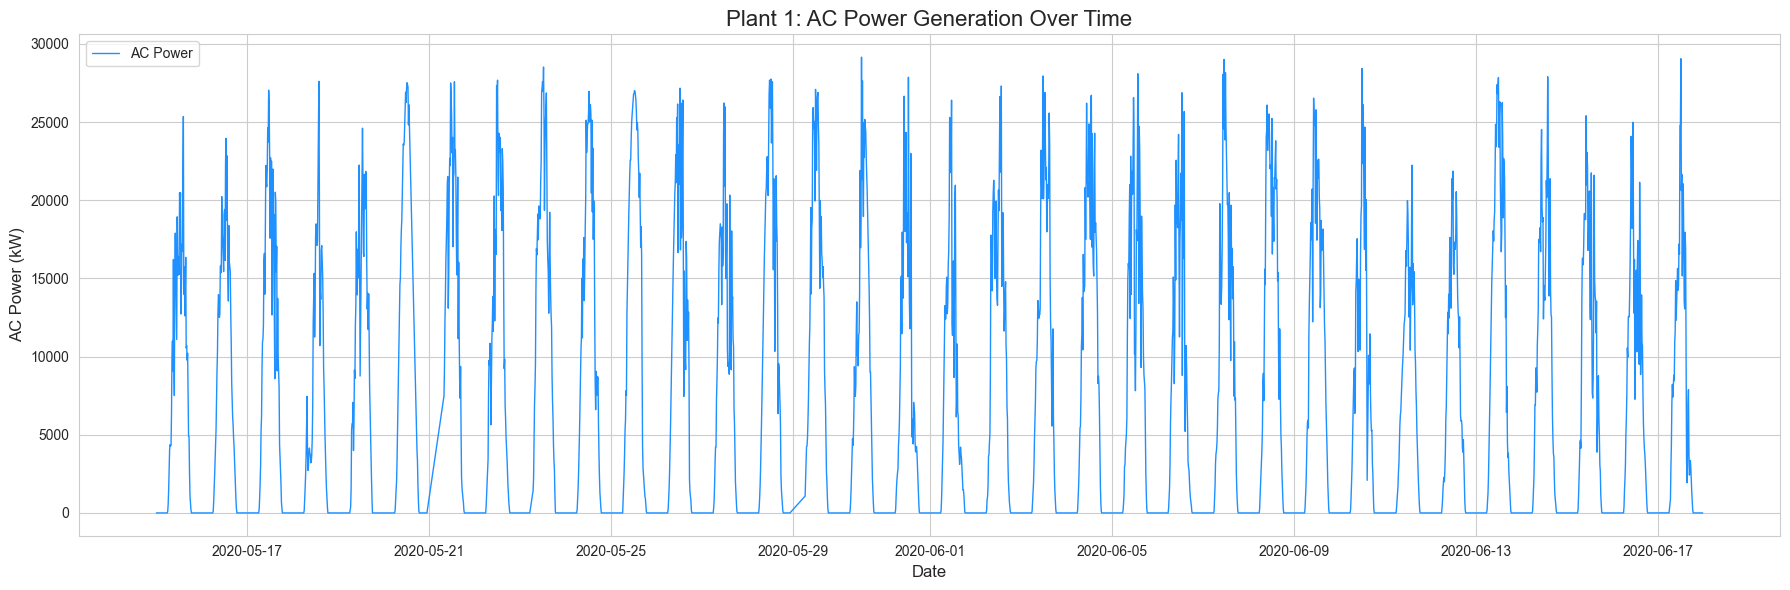

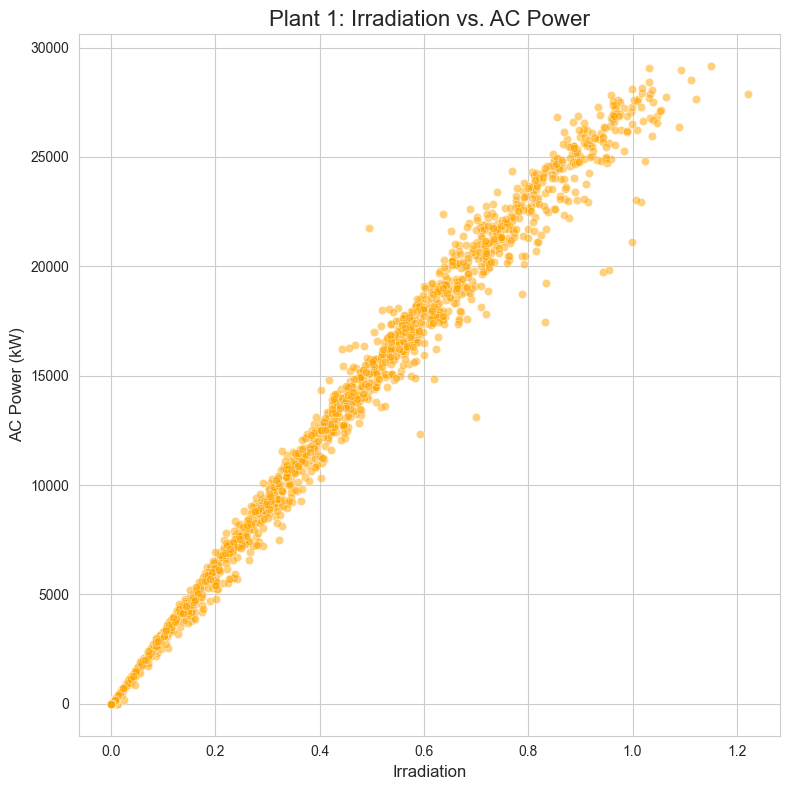

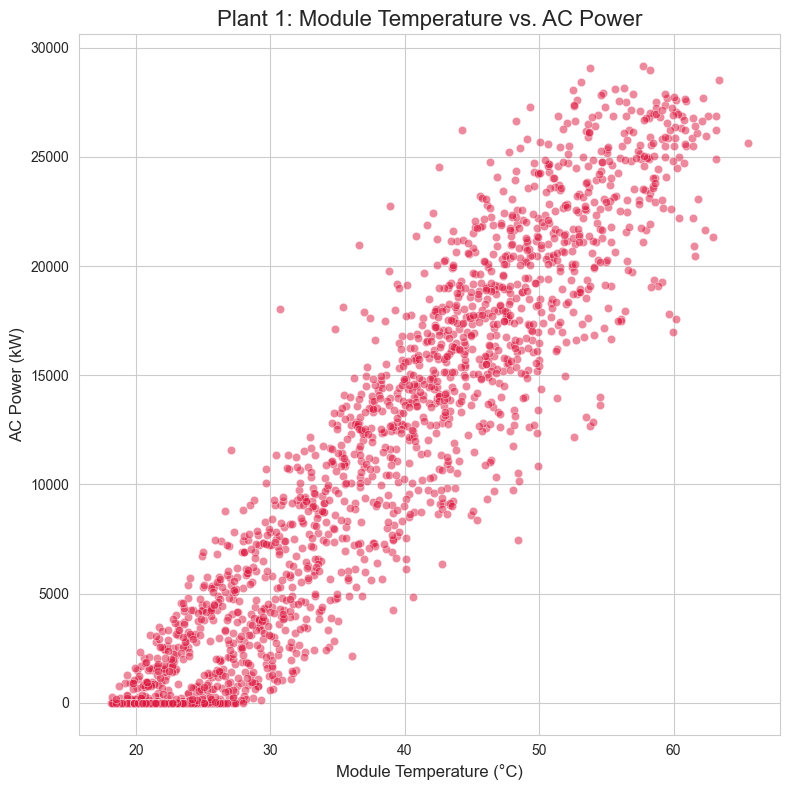

In [6]:
# Ensure the figures directory exists
figures_dir = '../reports/figures/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# --- Plot 1: AC Power Output over Time ---
plt.figure(figsize=(18, 6))
plt.plot(plant1_df['DATE_TIME'], plant1_df['AC_POWER'], label='AC Power', color='dodgerblue', linewidth=1)
plt.title('Plant 1: AC Power Generation Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AC Power (kW)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '01_p1_ac_power_timeseries.png'))
plt.show()

# --- Plot 2: Irradiation vs. AC Power ---
plt.figure(figsize=(8, 8))
sns.scatterplot(data=plant1_df, x='IRRADIATION', y='AC_POWER', alpha=0.5, color='orange')
plt.title('Plant 1: Irradiation vs. AC Power', fontsize=16)
plt.xlabel('Irradiation', fontsize=12)
plt.ylabel('AC Power (kW)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '02_p1_irradiation_vs_ac_power.png'))
plt.show()

# --- Plot 3: Module Temperature vs. AC Power ---
plt.figure(figsize=(8, 8))
sns.scatterplot(data=plant1_df, x='MODULE_TEMPERATURE', y='AC_POWER', alpha=0.5, color='crimson')
plt.title('Plant 1: Module Temperature vs. AC Power', fontsize=16)
plt.xlabel('Module Temperature (°C)', fontsize=12)
plt.ylabel('AC Power (kW)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_p1_temp_vs_ac_power.png'))
plt.show()

## End of Notebook 1

We have successfully completed the initial **Data Understanding** phase. Our key accomplishments are:
- Ingested and reviewed all raw data sources.
- Cleaned, aggregated, and merged the data into an analysis-ready format.
- Performed initial EDA, confirming the strong relationship between weather features and power output.

**Next Step:** Proceed to the next notebook, `02_Feature_Engineering_and_Modeling.ipynb`, to continue with **Phase 3: Data Preparation** and begin **Phase 4: Modeling**.